In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from numba import jit
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [3]:
pd.options.display.max_columns = 50

In [4]:
CAL_DTYPES={"event_name_2": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

### Path

In [5]:
path = Path('/kaggle/m5_forecasting/')
assert(path.exists())

In [6]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [7]:
def prepare_tables():
    prices = pd.read_csv(path/"sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv(path/"calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
#     boolean_attrs = ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
#     for ba in boolean_attrs:
#         cal[ba] = getattr(cal['date'].dt, ba.lower()).astype('uint8')
    
    return prices, cal

In [8]:
%%time

prices, cal = prepare_tables()

CPU times: user 1.4 s, sys: 184 ms, total: 1.58 s
Wall time: 1.58 s


In [9]:
def create_event_map(field):
    return {v: k for k, v in enumerate(cal[field].unique())}

In [10]:
def convert_to_type(df, cols, dt_type):
    for type_name in cols:
        df[type_name] = df[type_name].astype(dt_type)

def convert_uint8(df, cols):
    convert_to_type(df, cols, "uint8")
    
def convert_float16(df, cols):
    convert_to_type(df, cols, "float16")

In [11]:
def replace_cal_cols():
    event_name_1_map = create_event_map('event_name_1')
    cal.replace({'event_name_1': event_name_1_map}, inplace=True)
    event_type_1_map = create_event_map('event_type_1')
    cal.replace({'event_type_1': event_type_1_map}, inplace=True)
    return event_name_1_map, event_type_1_map

event_name_1_map, event_type_1_map = replace_cal_cols()

In [12]:
cal[cal.date == '2012-01-01']

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
337,2012-01-01,11149,3,2,1,2012,d_338,27,3,0,0,1.0,1.0,0.0


In [13]:
uint8_types= ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'wday', 'weekday', 
              'snap_CA', 'snap_TX', 'snap_WI']
convert_uint8(cal, uint8_types)

In [14]:
def get_elapsed(dt, event_name='Christmas', col='event_name_1', event_map=event_name_1_map, before=False):
    dt.sort_values(['date'], ascending=[(not before)], inplace=True)
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    res = []
    event = event_map[event_name]
    for v,d in zip(dt[col].values, dt.date.values):
        if v == event:
            last_date = d
        elapsed = ((d-last_date).astype('timedelta64[D]') / day1)
        res.append(elapsed)
    field_name = f"{'before' if before else 'after'}_{event_name.lower().replace(' ', '_')}"
    dt[field_name] = res
    dt[field_name] = dt[field_name].fillna(0)
    dt[field_name] = dt[field_name].astype('int16')

In [15]:
# ellapsed_fields = ['Christmas', 'Easter', 'Ramadan starts']
# for f in ellapsed_fields:
#     get_elapsed(cal, f, 'event_name_1', event_name_1_map, False)

In [16]:
def add_mean_over_period(dt, period='weekday'):
    df_sales_id_period = dt[['id', 'sales', period]].groupby(['id', period])[['sales']].mean().reset_index()
    df_sales_id_period['sales'] = df_sales_id_period['sales'].astype('float16')
    df_sales_id_period.rename(columns={'sales': f'sales_by_{period}'}, inplace=True)
    return dt.merge(df_sales_id_period, on=['id', period], how='left')

In [17]:
day_of_year = 'Dayofyear'

def prepare_day_of_year(df):
    df[day_of_year] = getattr(df['date'].dt, day_of_year.lower()).astype('uint16')

In [18]:
def add_days_before(dt, day=25, month=12, col_name='before_christmas'):
    diff_list = []
    for d in cal['date']:
        target = datetime(d.year, month, day)
        diff = (target - d.to_pydatetime()).days
        if(diff < 0):
            christmas = datetime(d.year + 1, 12, 25)
            diff = (target - d.to_pydatetime()).days
        diff_list.append(diff)
    dt[col_name] = diff_list
    dt[col_name] = dt[col_name].astype('uint16')

In [19]:
add_days_before(cal)

In [20]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1969 non-null   datetime64[ns]
 1   wm_yr_wk          1969 non-null   int16         
 2   weekday           1969 non-null   uint8         
 3   wday              1969 non-null   uint8         
 4   month             1969 non-null   uint8         
 5   year              1969 non-null   int16         
 6   d                 1969 non-null   object        
 7   event_name_1      1969 non-null   uint8         
 8   event_type_1      1969 non-null   uint8         
 9   event_name_2      1969 non-null   uint8         
 10  event_type_2      1969 non-null   uint8         
 11  snap_CA           1969 non-null   uint8         
 12  snap_TX           1969 non-null   uint8         
 13  snap_WI           1969 non-null   uint8         
 14  before_christmas  1969 n

In [21]:
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0,0,0,330
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0,0,0,329
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0,0,0,328
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1,1,0,327
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1,0,1,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,6,5,6,2016,d_1965,0,0,0,0,0,1,1,193
1965,2016-06-16,11620,4,6,6,2016,d_1966,0,0,0,0,0,0,0,192
1966,2016-06-17,11620,0,7,6,2016,d_1967,0,0,0,0,0,0,0,191
1967,2016-06-18,11621,2,1,6,2016,d_1968,0,0,0,0,0,0,0,190


In [22]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    
    start_day = max(1, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(path/"sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt.sort_values(['id', 'date'], inplace=True)
    prepare_day_of_year(dt)
    
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "year": "year",
        "mday": "day",
    }
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
            
    uint8_types= ['month', 'wday', 'mday', 'week']
    convert_uint8(dt, uint8_types)
    
    return dt

In [23]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [24]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)

CPU times: user 38 s, sys: 5.33 s, total: 43.4 s
Wall time: 43.4 s


In [25]:
convert_uint8(df, ['dept_id', 'store_id', 'cat_id', 'state_id'])
convert_float16(df, ['sales', 'sell_price'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 4081 to 46025082
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           uint8         
 3   store_id          uint8         
 4   cat_id            uint8         
 5   state_id          uint8         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  bef

In [27]:
def prepare_date_boolean_attrs(df, boolean_attrs):
    for ba in boolean_attrs:
        df[ba] = getattr(df['date'].dt, ba.lower()).astype('uint8')

In [28]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)
    print('lags', lags)
        
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            for stat in ['mean']:
                dt[f"r{stat}_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(
                    lambda x : x.rolling(win).agg(stat))
                print(f"r{stat}_{lag}_{win}")
                
    print('wins', wins)
    
    for simple_lag in range(1, 3):
        dt[f'lag_{simple_lag}'] = dt[["id","sales"]].groupby("id")["sales"].shift(simple_lag)
        
    print('simple_lags', range(1, 3))
        
    dt[f'lag_price_1'] = dt[["id","sell_price"]].groupby("id")["sell_price"].shift(1)
    
    for lag_col in lag_cols:
        del dt[lag_col]

In [29]:
%%time

create_fea(df)

lags [7, 28]
rmean_7_7
rmean_28_7
rmean_7_28
rmean_28_28
wins [7, 28]
simple_lags range(1, 3)
CPU times: user 1min 26s, sys: 5.92 s, total: 1min 32s
Wall time: 1min 32s


In [30]:
df.dropna(inplace = True)
df.shape

(44351007, 33)

In [31]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,before_christmas,sell_price,Dayofyear,week,mday,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,lag_1,lag_2,lag_price_1
45956915,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1909,0.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0,0,0,249,1.0,111,16,20,0.0,0.0,0.0,0.107117,0.0,0.0,1.0
45956916,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1910,0.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0,0,0,248,1.0,112,16,21,0.0,0.0,0.0,0.107117,0.0,0.0,1.0
45956917,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1911,0.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0,0,0,247,1.0,113,16,22,0.0,0.0,0.0,0.107117,0.0,0.0,1.0
46025081,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0,0,0,246,1.0,114,16,23,0.0,0.0,0.0,0.107117,0.0,0.0,1.0
46025082,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0,0,0,245,1.0,115,16,24,0.0,0.0,0.0,0.071411,0.0,0.0,1.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44351007 entries, 622628 to 46025082
Data columns (total 33 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           uint8         
 3   store_id          uint8         
 4   cat_id            uint8         
 5   state_id          uint8         
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           uint8         
 11  wday              uint8         
 12  month             uint8         
 13  year              int16         
 14  event_name_1      uint8         
 15  event_type_1      uint8         
 16  event_name_2      uint8         
 17  event_type_2      uint8         
 18  snap_CA           uint8         
 19  snap_TX           uint8         
 20  snap_WI           uint8         
 21  b

In [33]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X = df[train_cols]
Y = df["sales"]

np.random.seed(777)

In [34]:
len(train_cols)

27

In [35]:
# df.to_pickle(path/'m5_dt')
# !du -h {path/'m5_dt'}

In [36]:
del df
gc.collect()

60

In [37]:
params = {
#         "objective" : "poisson",
        "objective" : "tweedie",
#         "objective" : "mse",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "nthread" : 10,
        "metric": ["rmse"],
        'verbosity': 100,
        'num_leaves': 128,
        "min_data_in_leaf": 100,
        "n_estimators": 1200
}

In [38]:
%%time

num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True)
models = []
for fold, (train_idx, valid_idx) in enumerate(tqdm(kf.split(X), total=num_splits)):
    print(f'Fold: {fold+1}')
    x_train, x_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_val = Y.iloc[train_idx], Y.iloc[valid_idx]
    train_set = lgb.Dataset(x_train, y_train, categorical_feature=cat_feats)
    val_set = lgb.Dataset(x_val, y_val, categorical_feature=cat_feats)
    m_lgb = lgb.LGBMRegressor(**params)
    m_lgb.fit(X=x_train, y=y_train, eval_set=[(x_val, y_val)], eval_names=['sales'],eval_metric=params['metric'], 
              verbose=params['verbosity'], early_stopping_rounds=100)
    models.append(m_lgb)

Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	sales's rmse: 2.26358
[200]	sales's rmse: 2.23197
[300]	sales's rmse: 2.21865
[400]	sales's rmse: 2.20999
[500]	sales's rmse: 2.20385
[600]	sales's rmse: 2.19858
[700]	sales's rmse: 2.19449
[800]	sales's rmse: 2.18994
[900]	sales's rmse: 2.18797
[1000]	sales's rmse: 2.18631
[1100]	sales's rmse: 2.1848
[1200]	sales's rmse: 2.18319
Did not meet early stopping. Best iteration is:
[1198]	sales's rmse: 2.18312
Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	sales's rmse: 2.29806
[200]	sales's rmse: 2.27195
[300]	sales's rmse: 2.26011
[400]	sales's rmse: 2.25226
[500]	sales's rmse: 2.24685
[600]	sales's rmse: 2.24112
[700]	sales's rmse: 2.23804
[800]	sales's rmse: 2.23521
[900]	sales's rmse: 2.23238
[1000]	sales's rmse: 2.22869
[1100]	sales's rmse: 2.22504
[1200]	sales's rmse: 2.22317
Did not meet early stopping. Best iteration is:
[1200]	sales's rmse: 2.22317
Fold: 3
Training until valida

In [48]:
class Importance():
    
    def __init__(self, models, eval_metric):
        self.models, self.eval_metric = models, eval_metric
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        for model in self.models:
            fold_importance = pd.DataFrame(list(zip(train_cols, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
        self.feature_importances['importance'] = self.feature_importances['importance'].astype('float32')

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


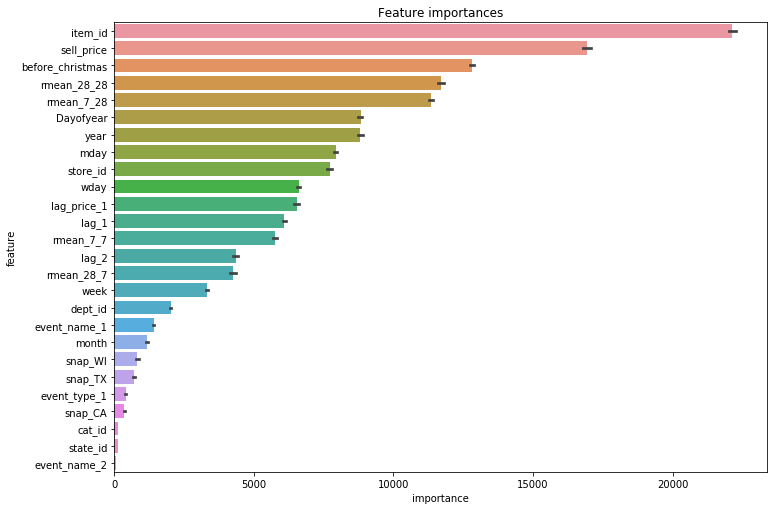

In [49]:
importance = Importance(models, 'rmse')
importance.plot_feature_importance(top_n=40)

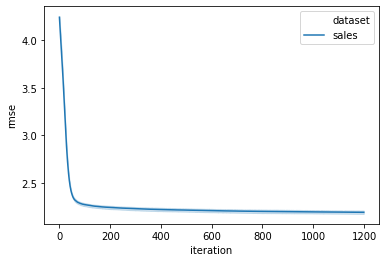

In [50]:
importance.plot_metric()

In [51]:
for i, m_lgb in enumerate(models):
    m_lgb.booster_.save_model(str(path/f"m5_model_{i}.lgb"))

In [57]:
!tar -czvf {path/"m5_models.tgz"} {path/"m5_model_*.lgb"}

tar: Removing leading `/' from member names
/kaggle/m5_forecasting/m5_model_0.lgb
/kaggle/m5_forecasting/m5_model_1.lgb
/kaggle/m5_forecasting/m5_model_2.lgb
/kaggle/m5_forecasting/m5_model_3.lgb
/kaggle/m5_forecasting/m5_model_4.lgb


In [58]:
!ls -latr {path}

total 4790556
-rw-r--r-- 1 root root     103469 Mar  2 02:48 calendar.csv
-rw-r--r-- 1 root root  120007726 Mar  2 02:48 sales_train_validation.csv
-rw-r--r-- 1 root root  203395785 Mar  2 02:48 sell_prices.csv
-rw-r--r-- 1 root root    5228786 Mar  2 02:48 sample_submission.csv
drwxr-xr-x 7 root root       4096 Apr 15 20:05 ..
-rw-rw-r-- 1 gilf gilf       4485 Apr 27 21:14 walmartTrends0.csv
-rw-r--r-- 1 root root     115092 Apr 30 11:27 m5_best_2.pth
-rw-r--r-- 1 root root 4435500355 May  2 20:08 m5_dt
-rw-r--r-- 1 root root     113891 May  2 20:29 m5_best_1.pth
-rw-r--r-- 1 root root   22049449 May  8 07:20 m5_model.lgb
-rw-r--r-- 1 root root   16793167 May  8 11:39 m5_model_0.lgb
-rw-r--r-- 1 root root   16825645 May  8 11:39 m5_model_1.lgb
-rw-r--r-- 1 root root   16821003 May  8 11:39 m5_model_2.lgb
-rw-r--r-- 1 root root   16793312 May  8 11:39 m5_model_3.lgb
-rw-r--r-- 1 root root   16822045 May  8 11:39 m5_model_4.lgb
drwxr-xr-x 2 root root       4096 May  8 11:41 .
-rw-r--r--

In [59]:
def run_predictions(models, df):
    y_pred = np.zeros((len(df), 1))
    print(y_pred.shape)
    for i, model in enumerate(models):
        y_pred += model.predict(df).reshape([len(df), 1])
    return y_pred / len(models)

In [60]:
%%time

alphas = [1.0]
weights = [1/len(alphas)]*len(alphas)
sub = 0.
cols = [f"F{i}" for i in range(1,29)]

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False, first_day=FIRST_DAY)

    for tdelta in tqdm(range(0, h), total=h):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day, train_cols]
        prediction = run_predictions(models, tst)
        te.loc[te.date == day, "sales"] = alpha * prediction

    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                          "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight

0 2016-04-25 00:00:00
lags [7, 28]
rmean_7_7
rmean_28_7
rmean_7_28
rmean_28_28
wins [7, 28]
simple_lags range(1, 3)
(30490, 1)
1 2016-04-26 00:00:00
lags [7, 28]
rmean_7_7
rmean_28_7
rmean_7_28
rmean_28_28
wins [7, 28]
simple_lags range(1, 3)
(30490, 1)
2 2016-04-27 00:00:00
lags [7, 28]
rmean_7_7
rmean_28_7
rmean_7_28
rmean_28_28
wins [7, 28]
simple_lags range(1, 3)
(30490, 1)
3 2016-04-28 00:00:00
lags [7, 28]


KeyboardInterrupt: 

In [ ]:
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

In [ ]:
!head submission.csv